# Loading data


## Install and Import packages 

In [1]:
!pip install tensorflow
!pip install Keras
!pip install opencv-python
!pip install mlxtend 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from mlxtend.preprocessing import minmax_scaling
from sklearn.metrics import roc_curve, auc

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.optimizers import RMSprop, SGD
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K
from shutil import copy
from shutil import copytree, rmtree
from collections import defaultdict
import collections

import os

## Split dataset into train and test 

In [3]:
# Helper method to split dataset 
def prepare_data(filepath, src, dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [4]:
# Train dataset 
print("Creating train data...")
# Change path  
prepare_data('/Users/rosetta/Desktop/food-101/meta/train.txt', '/Users/rosetta/Desktop/food-101/images', 'train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [5]:
# Test dataset
print("Creating test data...")
# Change path  
prepare_data('/Users/rosetta/Desktop/food-101/meta/test.txt', '/Users/rosetta/Desktop/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

### Data Argumentation

In [4]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255) 
train_generator = train_datagen.flow_from_directory(
        "/Users/rosetta/train",        # Change path
        target_size=(224,224),
        batch_size=64)
test_datagen = ImageDataGenerator(rescale=1/255) 
test_generator = test_datagen.flow_from_directory(
        "/Users/rosetta/test",        # Change path
        target_size=(224,224),
        batch_size=64)

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


## Mini Dataset 1 (3 categories)
### Create train_mini and test_mini
Took 6 hours to train three classes

In [8]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) 
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
    
food_list = ['apple_pie','pizza','omelette']     # Three classes 
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [12]:
# train_mini
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [13]:
# test_mini 
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


### Data Argumentation for mini data set 

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    "/Users/rosetta/train_mini",
    target_size=(299, 299),
    batch_size = 16,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    "/Users/rosetta/test_mini",
    target_size=(299, 299),
    batch_size = 16,
    class_mode='categorical')

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


# Model 

In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = 2250/16,
                    validation_data=validation_generator,
                    validation_steps= 750/16,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

# Save the model for future 
model.save('model_trained_3class.hdf5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
141/140 [==============================] - ETA: -1s - loss: 1.0765 - accuracy: 0.4938
Epoch 00001: val_loss improved from inf to 0.83391, saving model to best_model_3class.hdf5
141/140 [==============================] - 702s 5s/step - loss: 1.0765 - accuracy: 0.4938 - val_loss: 0.8339 - val_accuracy: 0.7187
Epoch 2/30
141/140 [==============================] - ETA: -1s - loss: 0.8388 - accuracy: 0.6911
Epoch 00002: val_loss improved from 0.83391 to 0.63384, saving model to best_model_3class.hdf5
141/140 [==============================] - 681s 5s/step - loss: 0.8388 - accuracy: 0.6911 - val_loss: 0.6338 - val_accuracy: 0.8293
Epoch 3/30
141/140 [==============================] - ETA: -1s - loss: 0.6814 - accuracy: 0.7524
Epoch 00003: val_loss improved from 0.63384 to 0.50504, saving model to best_model_3class.hdf5
141/140 [==============================] - 703s 5s/step - loss: 0.6814 - accuracy: 0.752

# Test
Run the following program if model is already trained (no need to rerun the model becuase it is already saved)

In [16]:
from tensorflow.keras.models import load_model

model_best = load_model('best_model_3class.hdf5', compile = False)

In [17]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.image as img
from tensorflow.keras.preprocessing import image
import numpy as np


food_list = ['apple_pie','pizza','omelette']

def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

### Import online images 
I found these pictures online and downloaded them (Different styles/angles/lighting...)

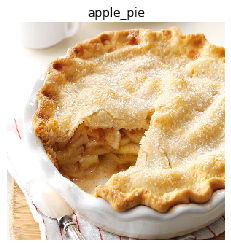

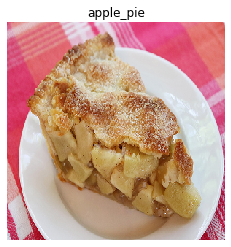

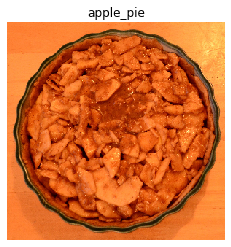

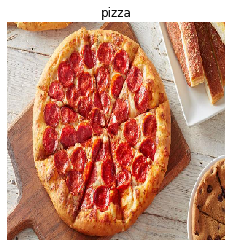

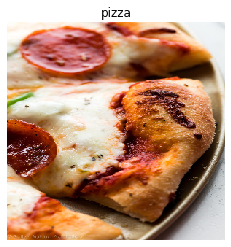

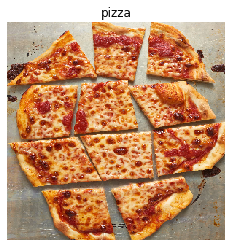

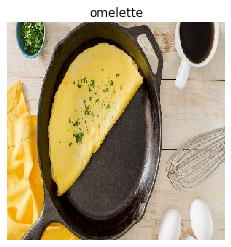

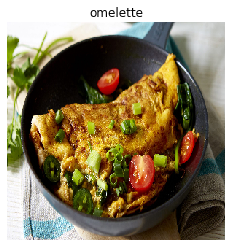

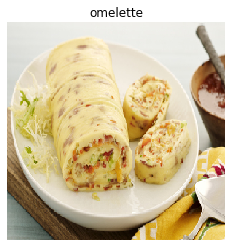

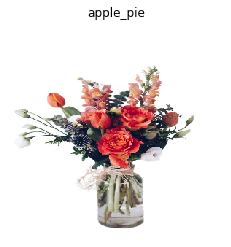

In [21]:
images = []

# Change path
images.append('/Users/rosetta/Downloads/applepie1.jpg')
images.append('/Users/rosetta/Downloads/applepie2.jpg')
images.append('/Users/rosetta/Downloads/applepie3.jpg')    

images.append('/Users/rosetta/Downloads/pizza1.jpg')
images.append('/Users/rosetta/Downloads/pizza2.jpg')
images.append('/Users/rosetta/Downloads/pizza3.jpg')

images.append('/Users/rosetta/Downloads/ome1.jpg')
images.append('/Users/rosetta/Downloads/ome2.jpg')
images.append('/Users/rosetta/Downloads/ome3.jpg')

images.append('/Users/rosetta/Downloads/flower.jpg')   # Shows that the model only recognizes three classes 

predict_class(model_best, images, True)

## Mini Dataset 2 (10 categories)

In [3]:
import random

data_dir = "/Users/rosetta/Desktop/food-101/images"
foods_sorted = sorted(os.listdir(data_dir))

def pick_n_random_classes(n):
  food_list10 = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list10.append(foods_sorted[i])
  food_list10.sort()
  return food_list10

In [4]:
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) 
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
    

In [5]:
n = 10
food_list10 = pick_n_random_classes(n)
print("These are the randomly picked food classes we will be training the model on...\n", food_list10)

src_train = 'train'
dest_train10 = 'train_mini10'
src_test = 'test'
dest_test10 = 'test_mini10'

These are the randomly picked food classes we will be training the model on...
 ['baklava', 'beet_salad', 'bread_pudding', 'chicken_quesadilla', 'french_fries', 'hot_and_sour_soup', 'macarons', 'onion_rings', 'scallops', 'waffles']


In [6]:
print("Creating training data folder with 11 classes...")
dataset_mini(food_list10, src_train, dest_train10)

Creating training data folder with 11 classes...
Copying images into baklava
Copying images into beet_salad
Copying images into bread_pudding
Copying images into chicken_quesadilla
Copying images into french_fries
Copying images into hot_and_sour_soup
Copying images into macarons
Copying images into onion_rings
Copying images into scallops
Copying images into waffles


In [7]:
print("Creating test data folder with 1 classes")
dataset_mini(food_list10, src_test, dest_test10)

Creating test data folder with 1 classes
Copying images into baklava
Copying images into beet_salad
Copying images into bread_pudding
Copying images into chicken_quesadilla
Copying images into french_fries
Copying images into hot_and_sour_soup
Copying images into macarons
Copying images into onion_rings
Copying images into scallops
Copying images into waffles


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    "/Users/rosetta/train_mini10",
    target_size=(299, 299),
    batch_size = 16,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    "/Users/rosetta/test_mini10",
    target_size=(299, 299),
    batch_size = 16,
    class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# change mini to 10

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_10class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_10class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = 7500/16,
                    validation_data=validation_generator,
                    validation_steps= 2500/16,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

# Save the model for future 
model.save('model_trained_10class.hdf5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
469/468 [==============================] - ETA: -1s - loss: 1.8883 - accuracy: 0.4271
Epoch 00001: val_loss improved from inf to 1.16668, saving model to best_model_11class.hdf5
469/468 [==============================] - 2387s 5s/step - loss: 1.8883 - accuracy: 0.4271 - val_loss: 1.1667 - val_accuracy: 0.7648
Epoch 2/30
469/468 [==============================] - ETA: -1s - loss: 1.1130 - accuracy: 0.7127
Epoch 00002: val_loss improved from 1.16668 to 0.65704, saving model to best_model_11class.hdf5
469/468 [==============================] - 2358s 5s/step - loss: 1.1130 - accuracy: 0.7127 - val_loss: 0.6570 - val_accuracy: 0.8632
Epoch 3/30
469/468 [==============================] - ETA: -1s - loss: 0.8117 - accuracy: 0.7876
Epoch 00003: val_loss improved from 0.65704 to 0.48974, saving model to best_model_11class.hdf5
469/468 [==============================] - 2424s 5s/step - loss: 0.8117 - accuracy:

KeyboardInterrupt: 

In [10]:
from tensorflow.keras.models import load_model

model_best10 = load_model('best_model_10class.hdf5', compile = False)

In [11]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.image as img
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list10.sort()
    pred_value = food_list10[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

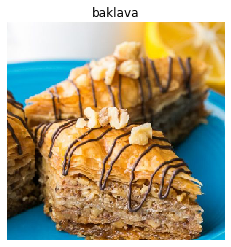

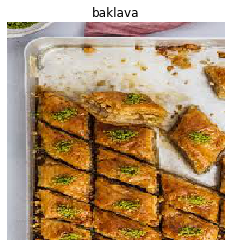

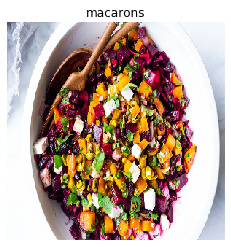

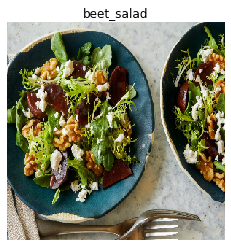

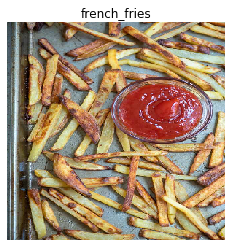

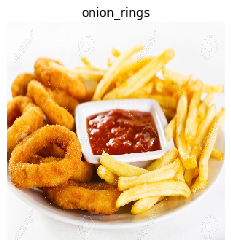

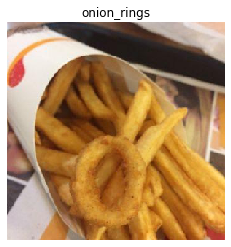

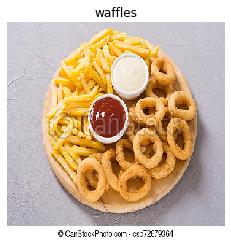

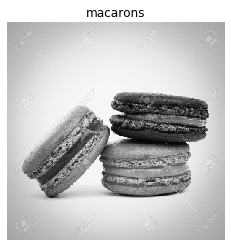

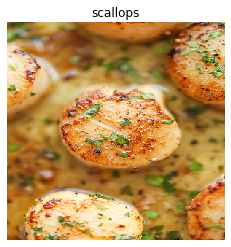

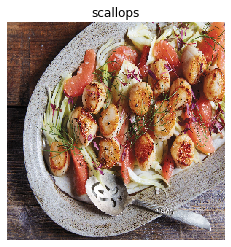

In [29]:
images = []

# Change path
images.append('/Users/rosetta/Downloads/baklava1.jpg')
images.append('/Users/rosetta/Downloads/baklava2.jpg')

images.append('/Users/rosetta/Downloads/beet1.jpg')    
images.append('/Users/rosetta/Downloads/beet2.jpeg')

# Burned fries
images.append('/Users/rosetta/Downloads/fries.jpg')

# Can only recognize one thing
images.append('/Users/rosetta/Downloads/onionAndFries.jpg')
images.append('/Users/rosetta/Downloads/onionAndFries3.jpg')


# Black and white works 
images.append('/Users/rosetta/Downloads/bwmacarons.jpg')

images.append('/Users/rosetta/Downloads/scallops1.jpg')
images.append('/Users/rosetta/Downloads/scallops2.jpg')

predict_class(model_best10, images, True)